# Second example with MPSA
This notebook is tied to the latex document "intro_to_mechanics", which briefly describes the theoretical foundations of the pure mechanics problem, and presents the results of experiments like this one.

# Setup
We aim to solve
\begin{equation}
\nabla\cdot \boldsymbol{\sigma} = \vec{f}
\end{equation}
under the following assumptions:
\begin{equation}
\boldsymbol{\sigma} = C : \boldsymbol{\epsilon} = 2\mu\boldsymbol{\epsilon} + \lambda \text{tr}(\boldsymbol{\epsilon}) \boldsymbol{I}
\end{equation}
where $\boldsymbol{\epsilon} = (\nabla u + (\nabla u)^T) /2$, and $\mu$ and $\lambda$ are the Lamé parameters. 

We consider a grid on $[0,1]\times [0,1]$. 

This time, we're interested to observe the effects of varying $\mu$ and $\lambda$. For simplicitly, each of their values will be homogeneous over the domain.

In [32]:
import porepy as pp
import scipy.sparse as sps
import numpy as np

In [33]:
def create_grid(n=8):
    physdims = [1,1]
    g = pp.CartGrid([n,n], physdims=physdims)
    g.compute_geometry()
    return g


def boundary_conditions(g):
    """ Set boundary conditions as in mpsa tutorial"""
    dirich = np.ravel(np.argwhere(g.face_centers[1] < 1e-10))
    labels = ['dir']*dirich.size
    bound = pp.BoundaryConditionVectorial(g, dirich, labels)

    # Boundary values
    tol = 1e-10
    top_faces = np.ravel(np.argwhere(g.face_centers[1] > 1 - tol))
    bot_faces = np.ravel(np.argwhere(g.face_centers[1] < tol))

    u_b = np.zeros((g.dim, g.num_faces))
    u_b[1, top_faces] = -1 * g.face_areas[top_faces]
    u_b[:, bot_faces] = 0

    u_b = u_b.ravel('F')
    
    return bound, u_b


def source_term(g):
    """ No sources"""
    return np.zeros(g.dim * g.num_cells)


def set_parameters(g, rock):
    # Set parameters. Choose from:
    # pp.UnitRock, pp.SandStone, pp.Shale, pp.Granite
    
    # Stiffness
    ones = np.ones(g.num_cells)
    lam = ones * rock.LAMBDA
    mu = ones * rock.MU
    C = pp.FourthOrderTensor(mu, lam)
    
    # BC
    bound, u_b = boundary_conditions(g)
    
    # Sources
    f = source_term(g)
    
    # Initialize data
    specified_parameters = {"fourth_order_tensor": C, "source": f, "bc": bound, "bc_values": u_b}
    data = pp.initialize_default_data(g, {}, "mechanics", specified_parameters)
    
    return g, data  

## Set up the problem for various rock types
We aim to solve the problem identical to `MPSA Tutorial`, but on different rock types - e.g. different values of $\mu$ and $\lambda$.

In [34]:
def rock_type(name):
    """ Select rock type"""
    if name == "UnitRock":
        return pp.UnitRock()
    elif name == "SandStone":
        return pp.SandStone()
    elif name == "Shale":
        return pp.Shale()
    elif name == "Granite":
        return pp.Granite()

def solve_for(rock_name):
    """ Solve MPSA tutorial problem for various rock types"""
    rock = rock_type(rock_name)
    
    n=8
    g = create_grid(n)
    g, data = set_parameters(g, rock)

    # Solve the system
    mpsa = pp.Mpsa("mechanics")
    mpsa.discretize(g, data)
    A, b = mpsa.assemble_matrix_rhs(g, data)
    u = sps.linalg.spsolve(A, b)

    # Traction on surfaces
    matrix_dictionary = data[pp.DISCRETIZATION_MATRICES]["mechanics"]
    parameter_dictionary = data[pp.PARAMETERS]["mechanics"]
    stress = matrix_dictionary["stress"]
    bound_stress = matrix_dictionary["bound_stress"]
    u_b = parameter_dictionary["bc_values"]

    T = stress * u + bound_stress * u_b
    T2d = np.reshape(T, (g.dim, -1), order='F')
    Tp = np.vstack((T2d, np.zeros(g.num_faces)))
    
    folder = "MPSA-intro-2"
    pp.save_img(f"{folder}/{rock_name}_displ-y", g, cell_value=u[1::2], figsize=(15, 12))
    pp.save_img(f"{folder}/{rock_name}_displ-x", g, cell_value=u[::2], figsize=(15, 12))
    pp.save_img(f"{folder}/{rock_name}_traction", g, vector_value=Tp, alpha=0, figsize=(15, 12))

## 1. UnitRock

/home/haakon/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


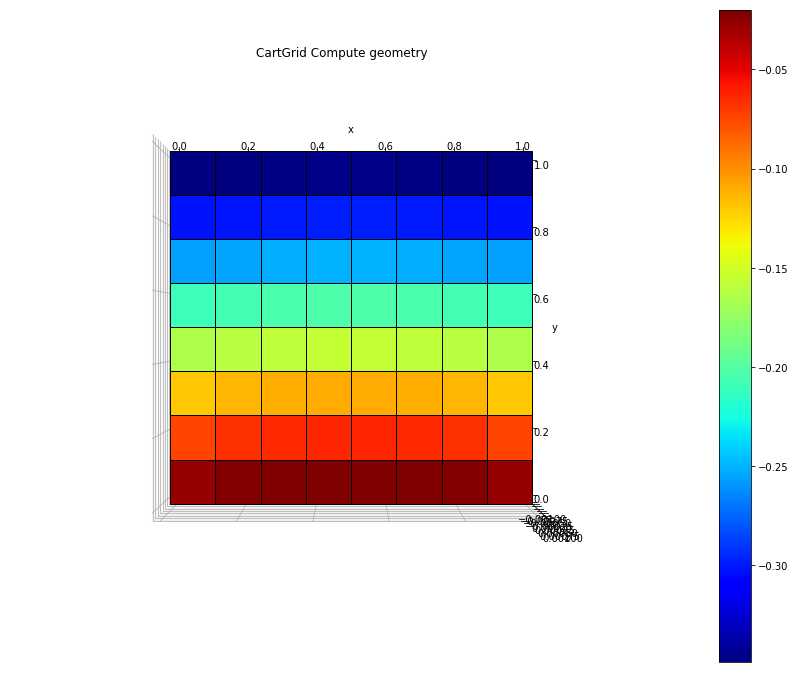

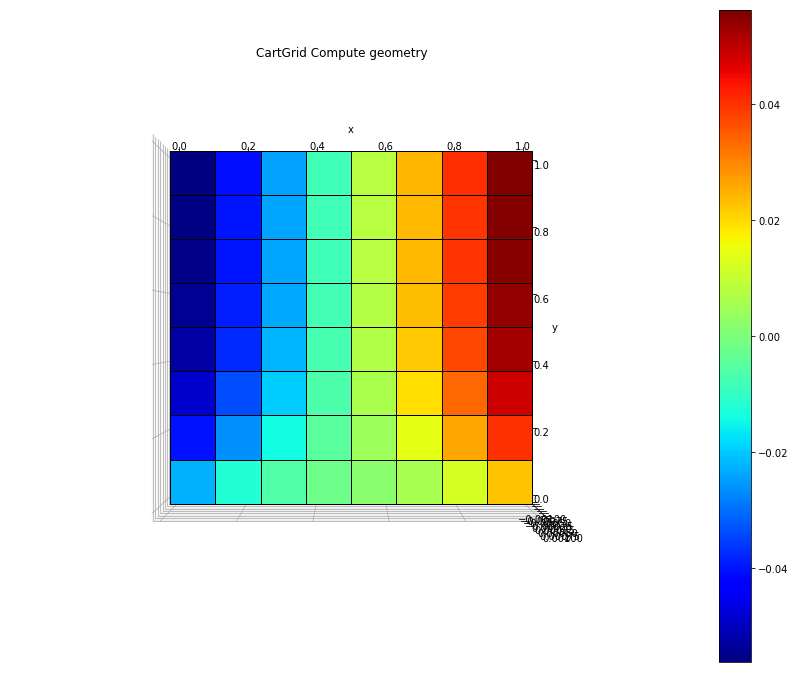

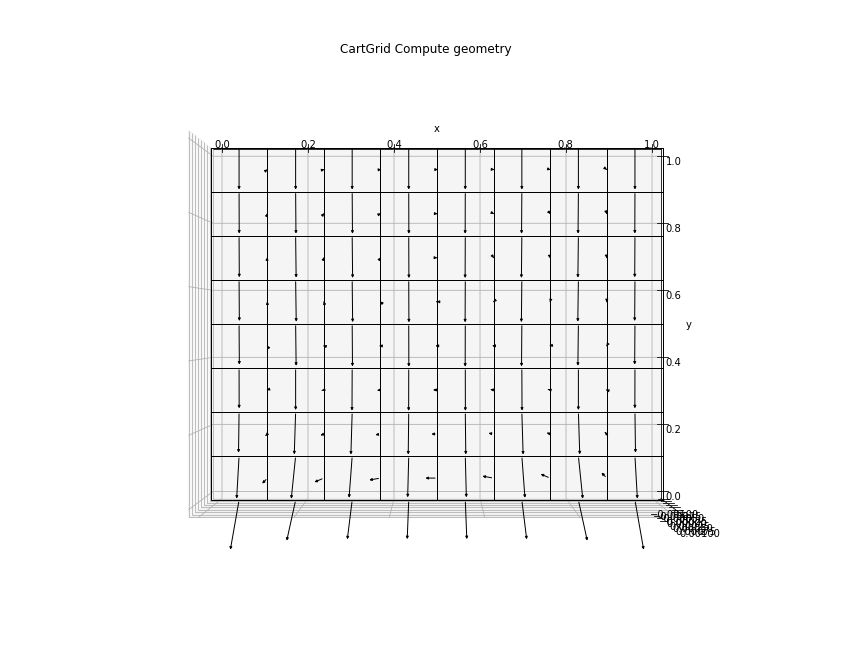

In [35]:
solve_for("UnitRock")

## 2. SandStone 

/home/haakon/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


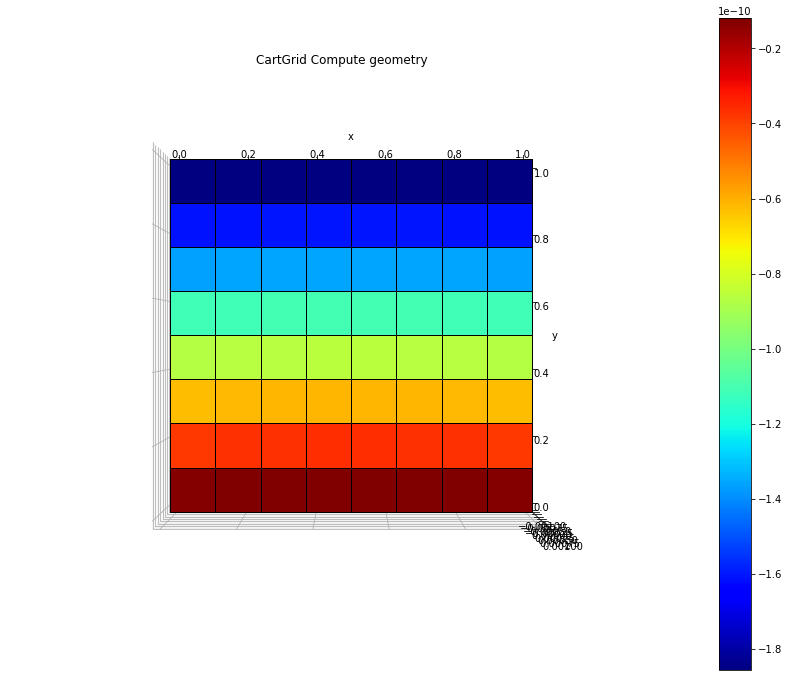

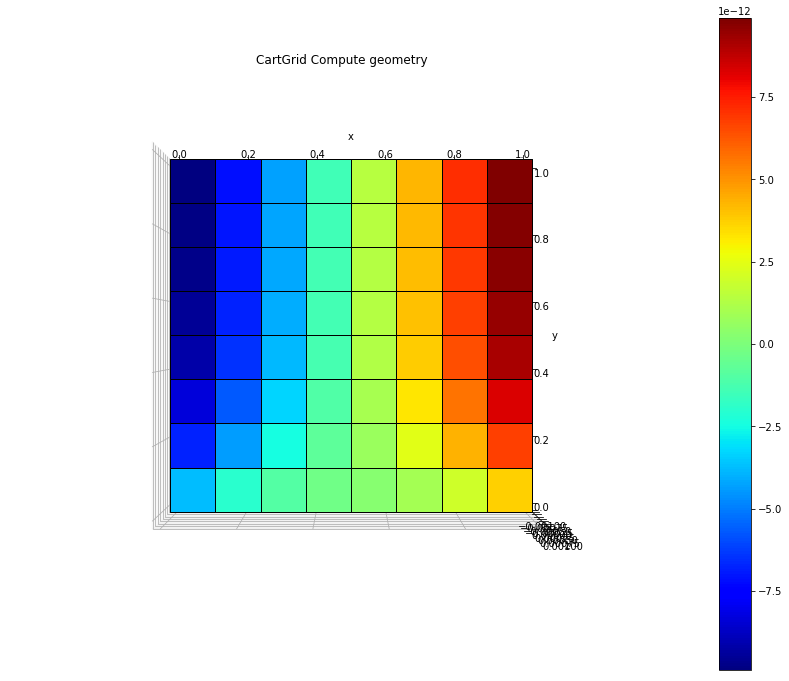

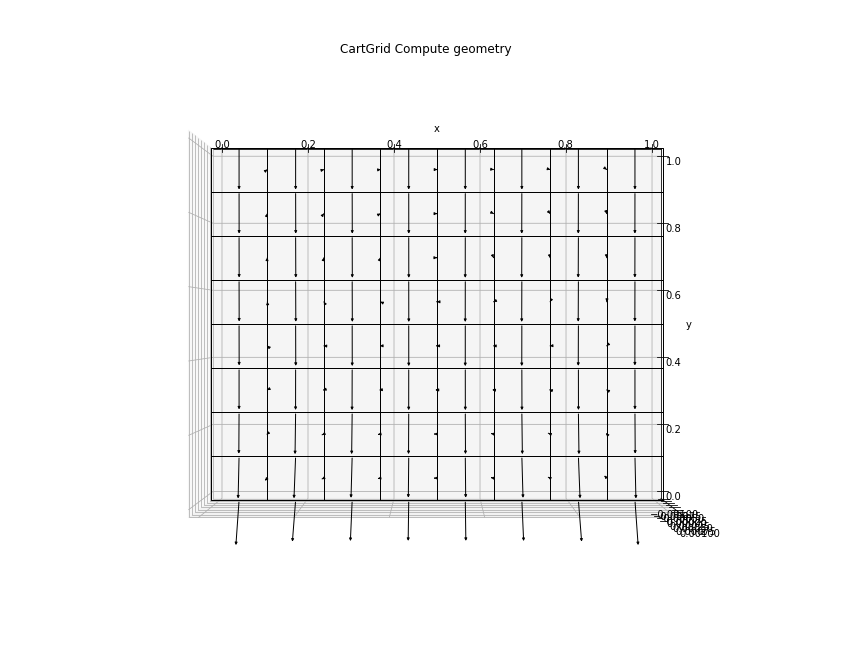

In [36]:
solve_for("SandStone")

## 3. Shale

/home/haakon/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


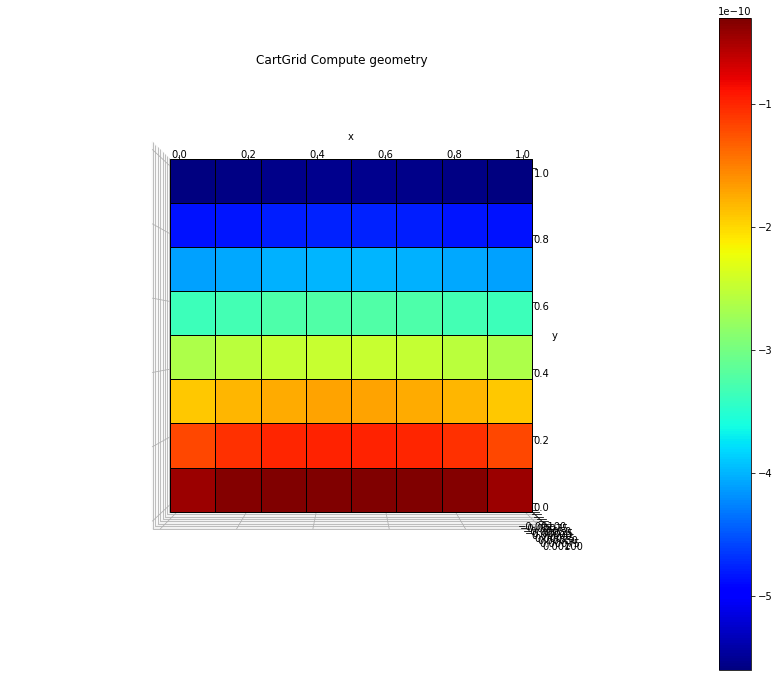

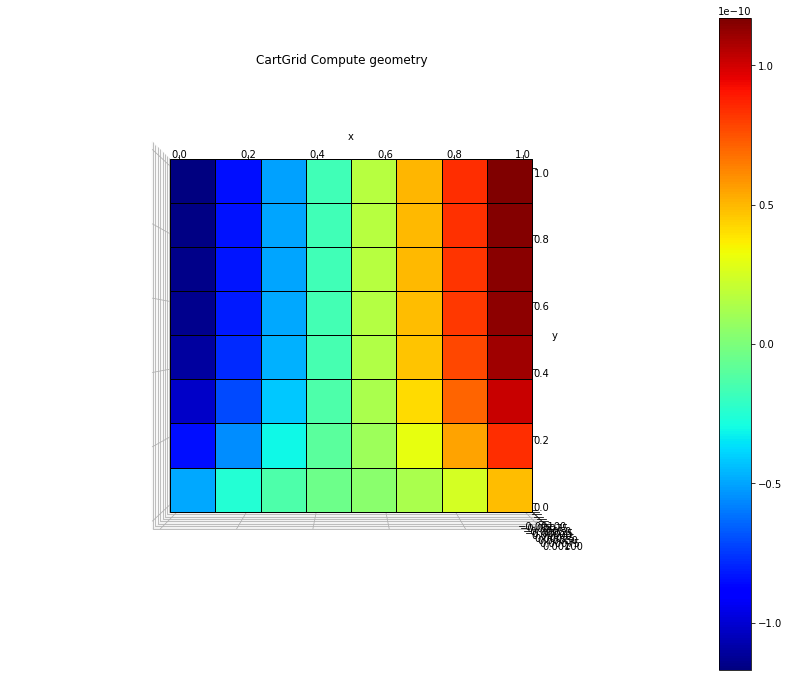

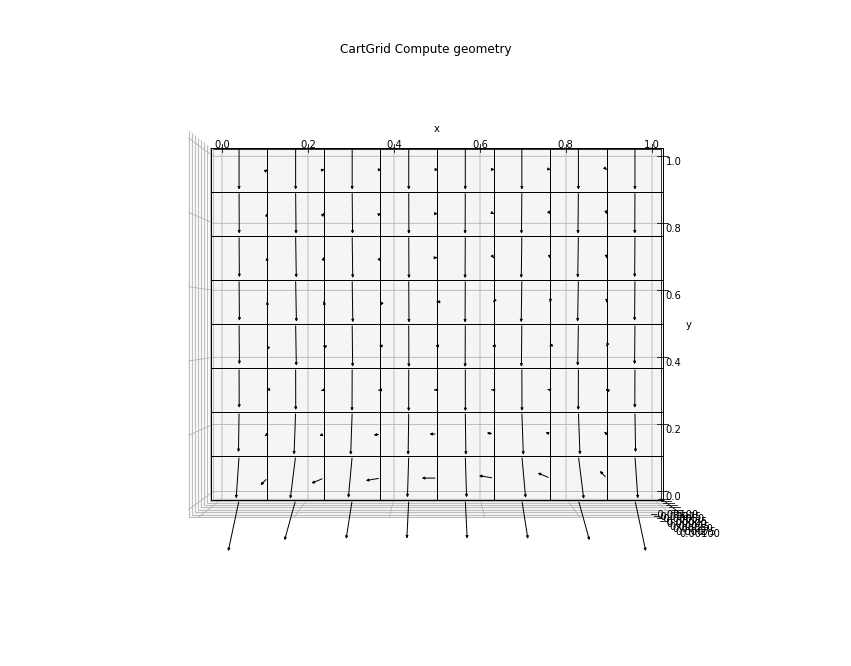

In [37]:
solve_for("Shale")

## 4. Granite 

/home/haakon/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


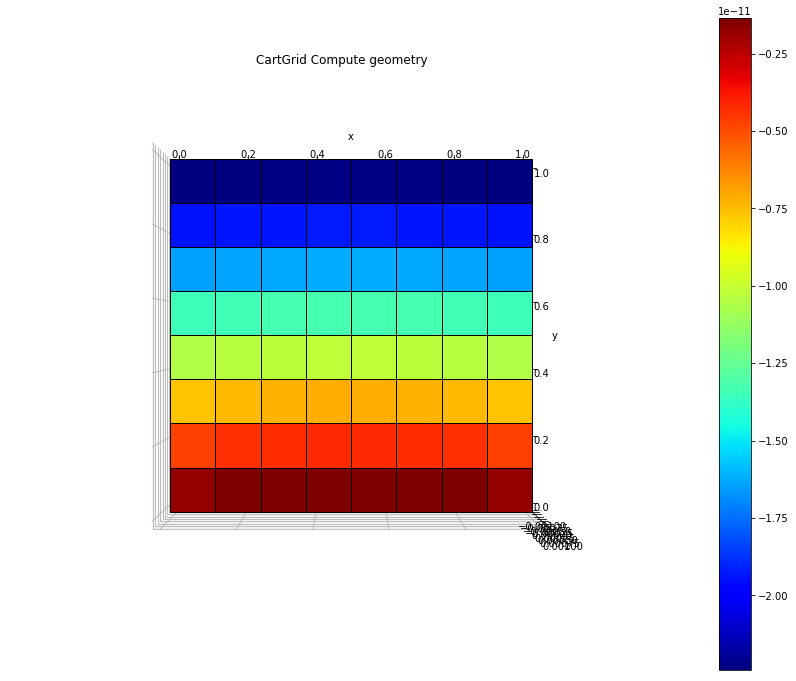

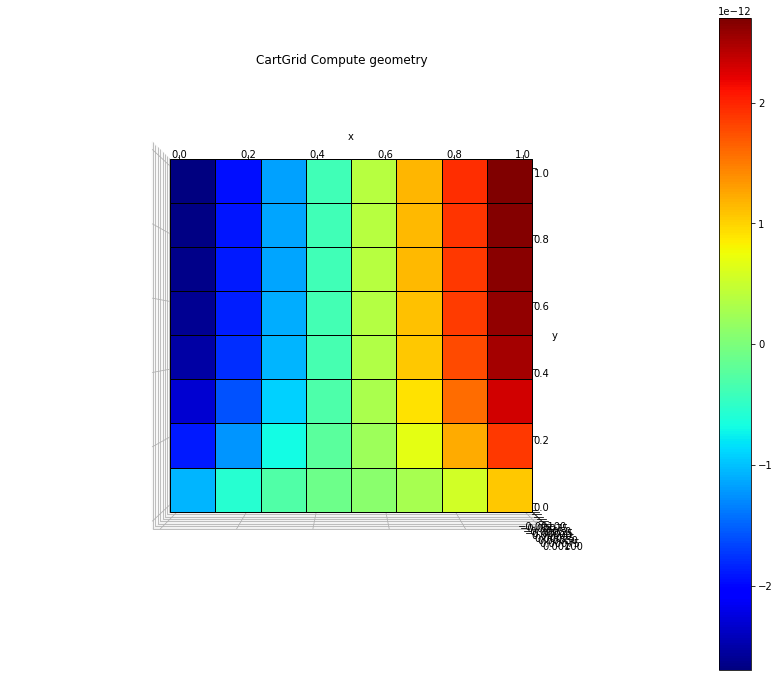

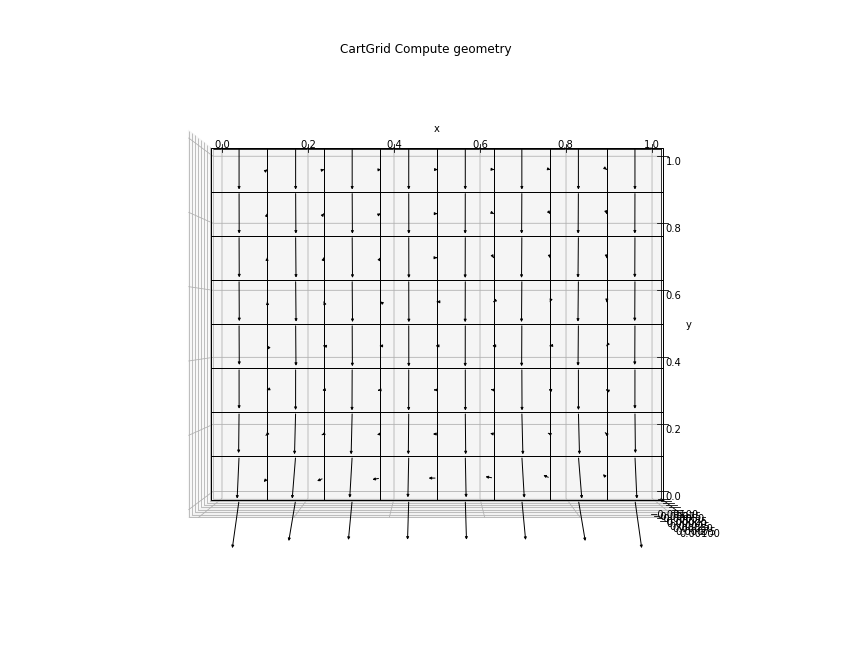

In [38]:
solve_for("Granite")